## Importation librairie

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import rich 
from rich.pretty import pprint
from tqdm import tqdm
from pandas import DataFrame

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV

In [ ]:
pd.set_option('display.max_columns', None)
os.getcwd()
df_train = pd.read_excel('drive/My Drive/Building_Energy_TRAIN.xlsx')
df_train.drop(['OSEBuildingID', 'DataYear', 'PropertyName', 'TaxParcelIdentificationNumber', 'NumberofBuildings'], axis=1, inplace=True)
print(f'la base fait {df_train.shape}')
df_train.head(5)

la base fait (1804, 14)


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding,ListOfAllPropertyUseTypes,LargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse_kBtu
0,Multifamily MR (5-9),Mid-Rise Multifamily,3,47.61272,-122.31761,2014,6,123075,31916,91159,"Multifamily Housing, Parking",Multifamily Housing,95.0,2759071.50
1,Nonresidential COS,Other,1,47.56548,-122.35378,1955,1,113780,0,113780,"Office, Other - Services",Other - Services,NaN,3574542.25
2,NonResidential,Other,7,47.60546,-122.33279,1930,6,103911,0,103911,"Fitness Center/Health Club/Gym, Office, Swimmi...",Fitness Center/Health Club/Gym,NaN,9956396.00
3,Multifamily MR (5-9),Mid-Rise Multifamily,7,47.62145,-122.35849,2001,6,80592,30583,50009,"Multifamily Housing, Parking",Multifamily Housing,NaN,1637794.75
4,Multifamily MR (5-9),Mid-Rise Multifamily,3,47.62543,-122.32691,2013,6,83296,0,83296,"Food Service, Multifamily Housing, Parking",Multifamily Housing,83.0,1957505.75


## Preprocessing Data

#### Cleaning up outliers

In [ ]:
def z_score(df, cols):
    tmp = df[cols]
    return tmp.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

In [ ]:
cols = ['NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding', 'ENERGYSTARScore']
z_scores = z_score(df_train, cols)

for col in cols: 
   z_scores = z_score(df_train, cols)
   print(z_scores.mean())


NumberofFloors        -5.711125e-17
PropertyGFATotal      -3.938707e-18
PropertyGFABuilding   -1.575483e-17
ENERGYSTARScore        2.330335e-16
dtype: float64
NumberofFloors        -5.711125e-17
PropertyGFATotal      -3.938707e-18
PropertyGFABuilding   -1.575483e-17
ENERGYSTARScore        2.330335e-16
dtype: float64
NumberofFloors        -5.711125e-17
PropertyGFATotal      -3.938707e-18
PropertyGFABuilding   -1.575483e-17
ENERGYSTARScore        2.330335e-16
dtype: float64
NumberofFloors        -5.711125e-17
PropertyGFATotal      -3.938707e-18
PropertyGFABuilding   -1.575483e-17
ENERGYSTARScore        2.330335e-16
dtype: float64


#### Dealing with NA  

In [ ]:
def na_per_column(df):
    na_counts = df.isna().sum()
    na_counts_sorted = na_counts.sort_values(ascending=False)
    na_percentages = na_counts_sorted / len(df) * 100
    result = pd.concat([na_counts_sorted, na_percentages], axis=1, keys=['Count', 'Percentage'])
    return result
    
na_train = na_per_column(df_train)
na_train

,Count,Percentage
ENERGYSTARScore,531,29.434590
LargestPropertyUseType,6,0.332594
BuildingType,0,0.000000
PrimaryPropertyType,0,0.000000
CouncilDistrictCode,0,0.000000
Latitude,0,0.000000
Longitude,0,0.000000
YearBuilt,0,0.000000
NumberofFloors,0,0.000000
PropertyGFATotal,0,0.000000


In [ ]:
med = df_train['ENERGYSTARScore'].median()
df_train['ENERGYSTARScore'].fillna(med, inplace=True)
df_train = df_train.dropna()
na_per_column(df_train)

,Count,Percentage
BuildingType,0,0.0
PrimaryPropertyType,0,0.0
CouncilDistrictCode,0,0.0
Latitude,0,0.0
Longitude,0,0.0
YearBuilt,0,0.0
NumberofFloors,0,0.0
PropertyGFATotal,0,0.0
PropertyGFAParking,0,0.0
PropertyGFABuilding,0,0.0


#### Converting categorical variables to dummies

In [ ]:
column_to_transform = ['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode']
X_train = pd.get_dummies(df_train, columns=column_to_transform)
print(f"on vient d'ajouter {X_train.shape[1] - df_train.shape[1]} colonnes")

on vient d'ajouter 34 colonnes


In [ ]:
def str2dummy(df: DataFrame, column_name, string: str) -> DataFrame:
    df['dummy_'+string] = [1 if string in x else 0 for x in df[column_name]]
    return df

types = ['Multifamily Housing', 'Office', 'Parking', 'Retail Store', 
         'Services', 'Warehouse', 'Wholesale Club/Supercenter', 'Other',
         'Swimming Pool', 'Fitness Center/Health Club/Gym', 'Food Service',
            'Data Center', 'Restaurant', 'Worship Facility', 'Laboratory',
            'Hotel', 'College/University', 'Senior Care Community', 'Distribution Center']

In [ ]:
for type in tqdm(types):
    X_train = str2dummy(X_train, 'ListOfAllPropertyUseTypes', type)

100%|██████████| 19/19 [00:00<00:00, 376.45it/s]


In [ ]:
X_train['Anciennete_bat'] = 2023 - X_train['YearBuilt'] 
X_train.drop(['ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'YearBuilt'], axis=1, inplace=True)

#### Preprocessing numerical variables

In [ ]:
numerical_vars =  ['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 
                'PropertyGFABuilding', 'ENERGYSTARScore', 'SiteEnergyUse_kBtu']

In [ ]:
def scale_features(df, feature):
    df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()
    return df

def unscale_features(df, feature):
    df[feature] = df[feature] * df[feature].std() + df[feature].mean()
    return df

In [ ]:
for var in tqdm(numerical_vars):
    X_train = scale_features(X_train, var)

100%|██████████| 6/6 [00:00<00:00, 524.26it/s]


#### Preparing data for sklearn

In [ ]:
y_train = X_train['SiteEnergyUse_kBtu']
X_train = X_train.drop(['SiteEnergyUse_kBtu'], axis = 1)
X_train.head(5)

,Latitude,Longitude,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding,ENERGYSTARScore,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,BuildingType_SPS-District K-12,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_High-Rise Multifamily,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mid-Rise Multifamily,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,dummy_Multifamily Housing,dummy_Office,dummy_Parking,dummy_Retail Store,dummy_Services,dummy_Warehouse,dummy_Wholesale Club/Supercenter,dummy_Other,dummy_Swimming Pool,dummy_Fitness Center/Health Club/Gym,dummy_Food Service,dummy_Data Center,dummy_Restaurant,dummy_Worship Facility,dummy_Laboratory,dummy_Hotel,dummy_College/University,dummy_Senior Care Community,dummy_Distribution Center,Anciennete_bat
0,47.61272,-122.31761,0.072062,0.005394,0.478694,-0.066061,1.063876,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
1,47.56548,-122.35378,-0.646164,-0.027223,-0.305904,0.017259,0.240206,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,68
2,47.60546,-122.33279,0.072062,-0.061854,-0.305904,-0.019092,0.240206,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,93
3,47.62145,-122.35849,0.072062,-0.143682,0.445925,-0.217630,0.240206,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22
4,47.62543,-122.32691,0.072062,-0.134193,-0.305904,-0.095023,0.569674,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,10


#### Feature selection

In [ ]:
mutual_info = mutual_info_regression(X_train, y_train)

In [ ]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)


PropertyGFATotal                    0.502514
PropertyGFABuilding                 0.460481
NumberofFloors                      0.145453
PropertyGFAParking                  0.104329
PrimaryPropertyType_Large Office    0.087861
                                      ...   
CouncilDistrictCode_5               0.000000
dummy_College/University            0.000000
PrimaryPropertyType_Retail Store    0.000000
BuildingType_SPS-District K-12      0.000000
dummy_Services                      0.000000
Length: 64, dtype: float64

<Axes: >

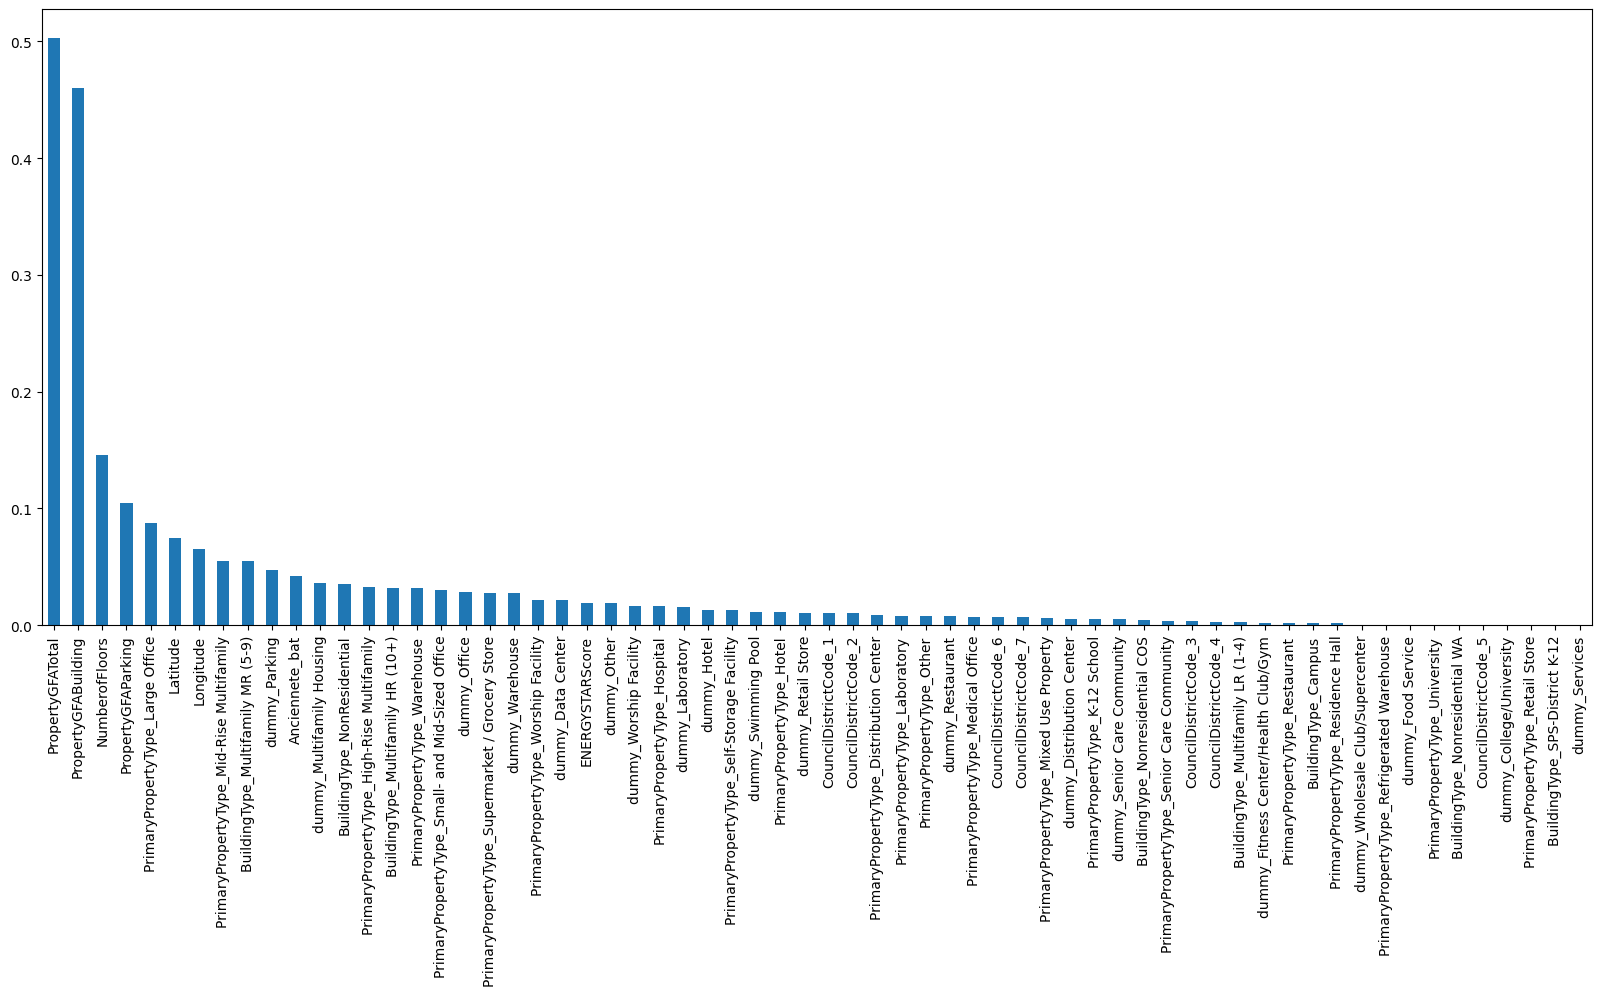

In [ ]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

## Modelization

On choisit les variables qui ont une information mutuelle > 0. On limite ainsi les problèmes de surapprentissage

In [ ]:
threshold = 0.05 # 5%
mutual_info_selected = mutual_info[mutual_info > threshold]
X_train = X_train[[col for col in X_train.columns if col in mutual_info_selected]]
X_train.shape

(1798, 9)

### Initialisation

In [ ]:
y_train = X_train.values
X_train = X_train.values

estimators = [
    DummyRegressor(), 
    LinearRegression(),
    Ridge(),
    KNeighborsRegressor(n_neighbors=10),
    DecisionTreeRegressor(), 
    RandomForestRegressor(),
    XGBRegressor(), 
]

results = {
    "train": {}, 
    "cross_validation_mean": {},
    "cross_validation_variance": {}
}


### Training 

In [ ]:
for estimator in tqdm(estimators):
    model = estimator
    model_name = model.__class__.__name__

    model.fit(X_train, y_train)

    cv_scores = cross_val_score(estimator, X_train, y_train, cv=5)
    results["cross_validation_mean"][model_name] = cv_scores.mean()
    results["cross_validation_variance"][model_name] = cv_scores.var()

    train_score = model.score(X_train, y_train)
    results["train"][model_name] = train_score

100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


### Selecting the best model

In [ ]:
pprint(results)

{
│   'train': {
│   │   'DummyRegressor': -1.973729821555834e-15,
│   │   'LinearRegression': 1.0,
│   │   'Ridge': 0.9675334228844057,
│   │   'KNeighborsRegressor': 0.8218411805495064,
│   │   'DecisionTreeRegressor': 1.0,
│   │   'RandomForestRegressor': 0.9717784745058794,
│   │   'XGBRegressor': 0.999958376816739
│   },
│   'cross_validation_mean': {
│   │   'DummyRegressor': -0.0038474952207479284,
│   │   'LinearRegression': 1.0,
│   │   'Ridge': 0.9581306595265471,
│   │   'KNeighborsRegressor': 0.826177133416528,
│   │   'DecisionTreeRegressor': 0.7031463456312916,
│   │   'RandomForestRegressor': 0.8537391554628403,
│   │   'XGBRegressor': 0.9699131120452265
│   },
│   'cross_validation_variance': {
│   │   'DummyRegressor': 3.859109352870541e-06,
│   │   'LinearRegression': 0.0,
│   │   'Ridge': 1.31820032631305e-06,
│   │   'KNeighborsRegressor': 0.0038381110100566703,
│   │   'DecisionTreeRegressor': 0.0023400145283717436,
│   │   'RandomForestRegressor': 0.003465422921297037,
│   │   'XGBRegressor': 0.002935788898695884
│   }
}

#### Optimisation 

In [ ]:
xgb = XGBRegressor() 

parameters =  {'max_depth': [3, 5, 7], 
               'n_estimators': [200, 300, 400],
               'learning_rate': [0.1, 0.01, 0.05]}


model_optimized = GridSearchCV(xgb, parameters)

In [ ]:
model_optimized.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [200, 300, 400]})

In [ ]:
cv_scores = cross_val_score(model_optimized, X_train, y_train, cv=3)
pprint(cv_scores)

### Prédiction

In [ ]:
X_test  =  pd.read_excel('drive/My Drive/Building_Energy_TEST.xlsx')
X_test.head(5)

In [ ]:
na_per_column(X_test)

In [ ]:
med = X_test['ENERGYSTARScore'].median()
X_test['ENERGYSTARScore'].fillna(med, inplace=True)
X_test = X_test.dropna()

In [ ]:
column_to_transform = ['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode']
X_test = pd.get_dummies(X_test, columns=column_to_transform)
print(f"on vient d'ajouter {X_test.shape[1] - df_train.shape[1]} colonnes")

on vient d'ajouter 36 colonnes


In [ ]:
def str2dummy(df, column_name, string):
    df['dummy_'+string] = [1 if string in x else 0 for x in df[column_name]]
    return df

types = ['Multifamily Housing', 'Office', 'Parking', 'Retail Store', 
         'Services', 'Warehouse', 'Wholesale Club/Supercenter', 'Other',
         'Swimming Pool', 'Fitness Center/Health Club/Gym', 'Food Service',
            'Data Center', 'Restaurant', 'Worship Facility', 'Laboratory',
            'Hotel', 'College/University', 'Senior Care Community', 'Distribution Center']

for type in tqdm(types):
    X_test = str2dummy(X_test, 'ListOfAllPropertyUseTypes', type)

X_test['Anciennete_bat'] = 2023 - X_test['YearBuilt'] 
X_test.drop(['ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'YearBuilt'], axis=1, inplace=True)

100%|██████████| 19/19 [00:00<00:00, 860.74it/s]


In [ ]:
numerical_vars = ['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding']
for var in tqdm(numerical_vars):
    X_test = scale_features(X_test, var)

100%|██████████| 4/4 [00:00<00:00, 509.70it/s]


In [ ]:
X_test = X_test[[col for col in X_test.columns if col in mutual_info_selected]]

,Latitude,Longitude,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding,BuildingType_Multifamily MR (5-9),PrimaryPropertyType_Large Office,PrimaryPropertyType_Mid-Rise Multifamily
0,47.60247,-122.33621,0.253545,0.053522,-0.267535,0.121570,0,1,0
1,47.58452,-122.33370,-0.797055,-0.573567,-0.267535,-0.548428,0,0,0
2,47.65014,-122.34424,-0.376815,-0.616677,-0.267535,-0.594488,0,0,0
3,47.62394,-122.31595,0.463665,-0.462294,-0.267535,-0.429542,1,0,1
4,47.60896,-122.33481,7.817865,3.888642,-0.267535,4.219109,0,1,0
...,...,...,...,...,...,...,...,...,...
446,47.56486,-122.37284,0.253545,-0.582362,-0.267535,-0.557825,1,0,1
447,47.62405,-122.33084,-0.797055,-0.295056,0.220540,-0.368321,0,0,0
448,47.62208,-122.35398,-0.797055,-0.617410,-0.267535,-0.595271,0,0,0
449,47.66246,-122.29898,-0.586935,-0.405251,-0.267535,-0.368595,0,0,0


In [ ]:
def export_csv(X_test, model):
    y_pred = pd.DataFrame(model.predict(X_test), columns=["y_pred"])
    y_pred.to_csv("y_pred.csv", index=False)

export_csv(X_test, xgb)

# X_test doesn't seem to have the right shape